In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# if one module is changed, this line will automatically reload that module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations, chain
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.io import savemat, loadmat
from scipy import stats
import warnings;
warnings.filterwarnings('ignore');
import sys
sys.path.insert(0, './aux/')
from plotting import plot_HvsN, plot_IvsN
import anndata as ad
import scanpy as sc
#import seaborn as sns
import os
#sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")

# First, apply StopWords to human pancreas data to obtain statistical information to detect housekeeping genes

In [2]:
sys.path.insert(0,'./StopWords/')
from stopwords import apply_stopwords
apply_stopwords(file_path='./data/Baron/baron_hp_UMI.csv', output_path='./output/baron_stopwords', output_name='baron_stopword-statistics')

In [3]:
# Construct human pancreas AnnData object
sourceDir='./data/Baron/'
files = os.listdir(sourceDir)
files.sort()
dat=[]
for fname in files[0:4]:
    try:
        dat.append(pd.read_csv(os.path.join(sourceDir, fname), index_col=0))
    except:
        continue
data=pd.concat(dat)
baron=None
baron = ad.AnnData(X=data.iloc[:, 2:], obs=data.iloc[:, :2])

AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'barcode', 'assigned_cluster'

In [4]:
# Load original data
df_wd = pd.read_csv('./data/Baron/baron_hp_UMI.csv',index_col=0,na_values=0).dropna(how='all',axis=0)#.to_sparse()
df_wd.fillna(0, inplace=True)
df_wd=df_wd.T

## Load StopWords statistics file

In [6]:
df = pd.read_csv('./output/Baron/baron_stopword-statistics_Ns1000.csv',index_col=0)
df

,F,I,tfidf,H,H-tilde,H-tilde_std,N
A1BG,8.810209e-07,0.083409,5.571486,5.368523,5.451932,0.019057,44
A1CF,3.842452e-05,0.321358,2.461418,10.307840,10.629199,0.016143,1919
A2M,9.430928e-06,1.015328,5.946046,7.792081,8.807409,0.017441,471
A4GALT,1.229425e-05,0.534686,4.093446,8.633224,9.167911,0.017814,614
AAAS,3.221733e-05,0.309822,2.583642,10.105621,10.415443,0.016145,1609
...,...,...,...,...,...,...,...
ZYG11B,3.614188e-05,0.243381,2.351386,10.311923,10.555304,0.016397,1805
ZYX,1.073644e-04,0.656205,2.307868,11.045576,11.701782,0.012845,5362
ZZEF1,3.179684e-05,0.286099,2.521628,10.113874,10.399974,0.015881,1588
ZZZ3,2.226580e-05,0.313203,2.914048,9.638936,9.952139,0.016227,1112


## Volcano plot of gene count vs gene information content

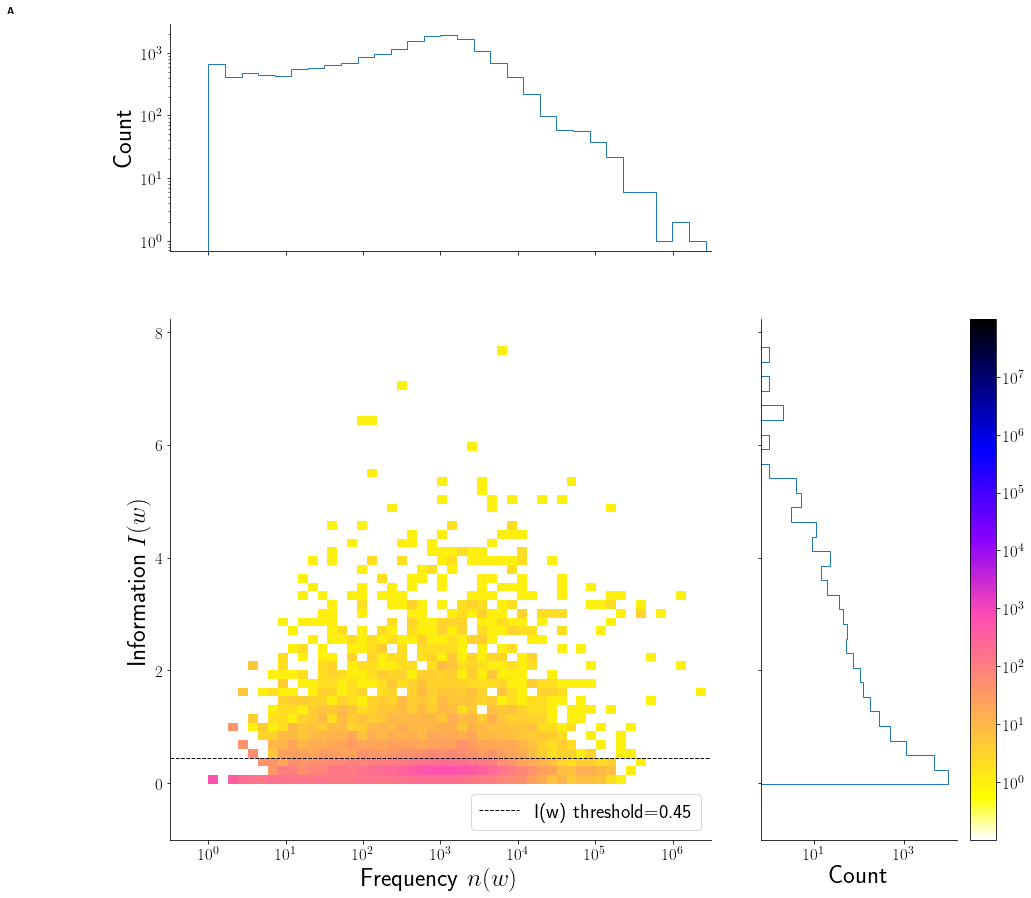

CPU times: user 3.87 s, sys: 338 ms, total: 4.21 s
Wall time: 4.9 s


In [32]:
%%time
thresh=0.45 #Cut-off thershold for the information content of genes
plot_IvsN(df, thresh, name='human_infor')

### We observe a large quantity of genes do not carry significant information as quantified by $I(w)$. Next, we visualize how far is each gene from a random distribution in terms of the entropy $H$. We observe that most genes carrying little information lie close to the random distribution (orange). The red markers indicate genes identified in literature as housekeeping genes. All genes above the $I*$ threshold are discarded.

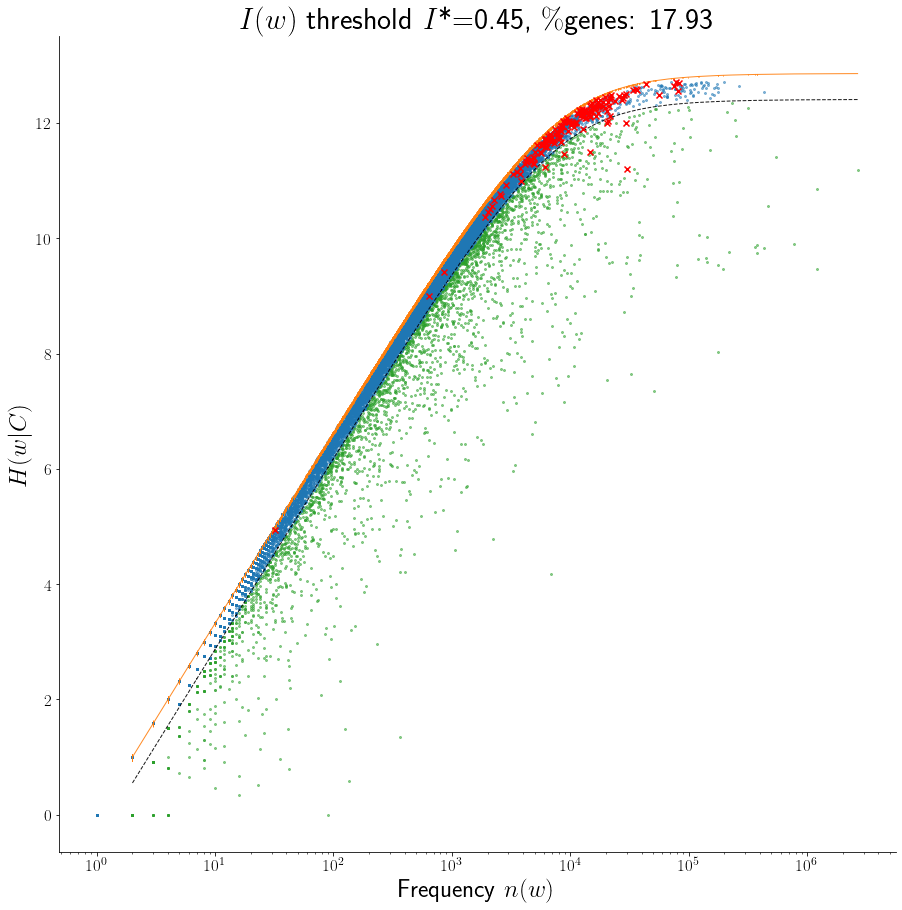

CPU times: user 5.08 s, sys: 246 ms, total: 5.33 s
Wall time: 4.91 s


In [31]:
%%time
plot_HvsN(df, thresh, baron.X.shape[0], hkg, name='human')

In [8]:
#Select all genes with information coefficient I larger than threshold
df_flt=df['I']>thresh
np.count_nonzero(df_flt)

3138

In [9]:
df_wd_flt=df_wd.loc[:, df_flt]
#When original data is first loaded by StopWords, zero entries are replaced with NaN.
#Replace back NaNs with 0's
df_wd_flt.fillna(0, inplace=True)
df_wd_flt

,A2M,A4GALT,AADAC,AADACP1,ABCA1,ABCA4,ABCA8,ABCB1,ABCB11,ABCC3,...,ZNF711,ZNF750,ZNF804A,ZNF836,ZP1,ZP4,ZSWIM3,ZSWIM4,ZYX,pk
human1_lib1.final_cell_0001,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0
human1_lib1.final_cell_0002,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
human1_lib1.final_cell_0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
human1_lib1.final_cell_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
human1_lib1.final_cell_0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
human4_lib3.final_cell_0697,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
human4_lib3.final_cell_0698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
human4_lib3.final_cell_0699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
human4_lib3.final_cell_0700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Selecting pairs of correlated genes according to a threshold value. All pairs of genes with correlation > threshold are selected.

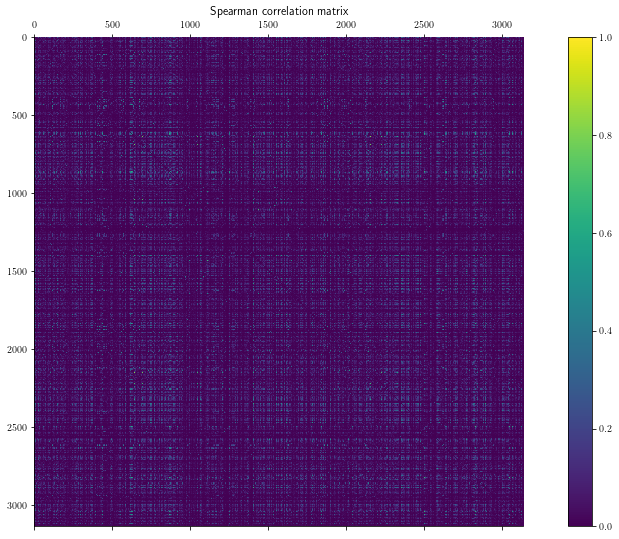

Matrix size (3138, 3138)


In [10]:
# Correlation matrix to select pairs of genes as vocabulary for Gene2Vec
rho, _ = stats.spearmanr(df_wd_flt.T.values, axis=1)
np.fill_diagonal(rho, 0)
plt.close('all')
plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(False)
cax = ax.matshow(np.abs(rho), vmin=0, vmax=1)
fig.colorbar(cax)
plt.title('Spearman correlation matrix')
plt.show()
print(f'Matrix size {rho.shape}')

In [12]:
corr_thresh=0.1 #Gene correlation threshold
correlated_genes = np.abs(rho)>corr_thresh #Filtering
np.count_nonzero(correlated_genes)

1260322

In [13]:
genes=list(df_wd_flt.columns)
len(genes)

3138

In [14]:
idxs=np.transpose(np.nonzero(correlated_genes))
len(np.unique(idxs))

3036

In [15]:
#idxs=np.transpose(np.nonzero(correlated_genes))
pairs=[(genes[i[0]], genes[i[1]] ) for i in idxs ]
len(pairs), len(np.unique(pairs))

(1260322, 3036)

In [16]:
pairs[:5] #Displaying the first five selected gene pairs

[('A2M', 'A4GALT'),
 ('A2M', 'ABCA1'),
 ('A2M', 'ABCA8'),
 ('A2M', 'ABCC8'),
 ('A2M', 'ABI3')]

In [17]:
#Setting up output file names and number of embedding dimensions for Gene2Vec
pairs_file='baron_stopwords_pairs_I-'+str(thresh)+'_rho-'+str(corr_thresh)+'.txt'
embeddings=400
fpath='./output/Baron/'+str(embeddings)+'emb/I-'+str(thresh)+'_rho-'+str(corr_thresh)+'/'
print(pairs_file)
print(fpath)

baron_stopwords_pairs_I-0.45_rho-0.1.txt
./output/Baron/400emb/I-0.45_rho-0.1/


In [18]:
#Writing gene pairs to a txt file
os.makedirs(os.path.dirname(fpath), exist_ok=True)
f = open(fpath+pairs_file, 'w')
for pair in pairs:
    #print(pair[0]+' '+pair[1]+'\n')
    f.write(pair[0]+' '+pair[1]+'\n')
f.close()


In [19]:
#Run Gene2Vec on the gene pairs txt file
#!python ./g2v/mouse_pancreas_SW_gene2vec.py
sys.path.insert(0, './g2v/')
from gene2vec import apply_gene2vec
emb_fpath=fpath+'/embeddings/'
os.makedirs(os.path.dirname(emb_fpath), exist_ok=True)
apply_gene2vec(embedding_dimension=embeddings, sourceDir=fpath, gene_pairs_file=pairs_file, export_dir=emb_fpath)


2022-04-11 20:55:54,734 : INFO : Gene pairs file: baron_stopwords_pairs_I-0.45_rho-0.1.txt


start!
2022-04-11 20:55:54.734513


2022-04-11 20:55:56,363 : INFO : shuffle start 1260322


2022-04-11 20:55:56.363679


2022-04-11 20:55:57,392 : INFO : shuffle done 1260322
2022-04-11 20:55:57,393 : INFO : collecting all words and their counts
2022-04-11 20:55:57,394 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-11 20:55:57,403 : INFO : PROGRESS: at sentence #10000, processed 20000 words, keeping 2372 word types
2022-04-11 20:55:57,414 : INFO : PROGRESS: at sentence #20000, processed 40000 words, keeping 2552 word types
2022-04-11 20:55:57,424 : INFO : PROGRESS: at sentence #30000, processed 60000 words, keeping 2645 word types
2022-04-11 20:55:57,434 : INFO : PROGRESS: at sentence #40000, processed 80000 words, keeping 2699 word types
2022-04-11 20:55:57,444 : INFO : PROGRESS: at sentence #50000, processed 100000 words, keeping 2737 word types
2022-04-11 20:55:57,454 : INFO : PROGRESS: at sentence #60000, processed 120000 words, keeping 2764 word types
2022-04-11 20:55:57,465 : INFO : PROGRESS: at sentence #70000, processed 140000 words, keeping 2786 word types
202

2022-04-11 20:55:57.392100


2022-04-11 20:55:57,596 : INFO : PROGRESS: at sentence #200000, processed 400000 words, keeping 2922 word types
2022-04-11 20:55:57,607 : INFO : PROGRESS: at sentence #210000, processed 420000 words, keeping 2924 word types
2022-04-11 20:55:57,617 : INFO : PROGRESS: at sentence #220000, processed 440000 words, keeping 2927 word types
2022-04-11 20:55:57,627 : INFO : PROGRESS: at sentence #230000, processed 460000 words, keeping 2929 word types
2022-04-11 20:55:57,638 : INFO : PROGRESS: at sentence #240000, processed 480000 words, keeping 2933 word types
2022-04-11 20:55:57,648 : INFO : PROGRESS: at sentence #250000, processed 500000 words, keeping 2941 word types
2022-04-11 20:55:57,659 : INFO : PROGRESS: at sentence #260000, processed 520000 words, keeping 2945 word types
2022-04-11 20:55:57,668 : INFO : PROGRESS: at sentence #270000, processed 540000 words, keeping 2949 word types
2022-04-11 20:55:57,679 : INFO : PROGRESS: at sentence #280000, processed 560000 words, keeping 2954 wor

2022-04-11 20:55:58,364 : INFO : PROGRESS: at sentence #930000, processed 1860000 words, keeping 3031 word types
2022-04-11 20:55:58,374 : INFO : PROGRESS: at sentence #940000, processed 1880000 words, keeping 3031 word types
2022-04-11 20:55:58,384 : INFO : PROGRESS: at sentence #950000, processed 1900000 words, keeping 3033 word types
2022-04-11 20:55:58,394 : INFO : PROGRESS: at sentence #960000, processed 1920000 words, keeping 3034 word types
2022-04-11 20:55:58,405 : INFO : PROGRESS: at sentence #970000, processed 1940000 words, keeping 3034 word types
2022-04-11 20:55:58,416 : INFO : PROGRESS: at sentence #980000, processed 1960000 words, keeping 3034 word types
2022-04-11 20:55:58,431 : INFO : PROGRESS: at sentence #990000, processed 1980000 words, keeping 3034 word types
2022-04-11 20:55:58,442 : INFO : PROGRESS: at sentence #1000000, processed 2000000 words, keeping 3034 word types
2022-04-11 20:55:58,452 : INFO : PROGRESS: at sentence #1010000, processed 2020000 words, keepi

2022-04-11 20:56:02,356 : INFO : training on a 2520644 raw words (2520644 effective words) took 3.1s, 818729 effective words/s
2022-04-11 20:56:02,357 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2022-04-11 20:56:02,357 : INFO : saving Word2Vec object under ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1, separately None
2022-04-11 20:56:02,358 : INFO : not storing attribute vectors_norm
2022-04-11 20:56:02,360 : INFO : not storing attribute cum_table
2022-04-11 20:56:02,445 : INFO : saved ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1
2022-04-11 20:56:02,445 : INFO : loading Word2VecKeyedVectors object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1
2022-04-11 20:56:02,513 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1.wv.* with mmap=None
2022-04-11 20:56:02,514 : INFO : setting ignore

2022-04-11 20:56:03.465431


2022-04-11 20:56:04,538 : INFO : shuffle done 1260322
2022-04-11 20:56:04,539 : INFO : gene2vec dimension 400 iteration 2 start
2022-04-11 20:56:04,539 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1
2022-04-11 20:56:04,610 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1.wv.* with mmap=None
2022-04-11 20:56:04,611 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:04,611 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1.vocabulary.* with mmap=None
2022-04-11 20:56:04,612 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_1.trainables.* with mmap=None
2022-04-11 20:56:04,613 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:04,614 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:04.538680


2022-04-11 20:56:05,656 : INFO : EPOCH 1 - PROGRESS: at 20.63% examples, 515159 words/s, in_qsize 63, out_qsize 0
2022-04-11 20:56:06,661 : INFO : EPOCH 1 - PROGRESS: at 55.14% examples, 690005 words/s, in_qsize 63, out_qsize 0
2022-04-11 20:56:07,347 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:07,352 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:07,367 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:07,392 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:07,392 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:07,393 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:07,394 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:07,394 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:07,396 : INFO : wor

2022-04-11 20:56:08.655341


2022-04-11 20:56:09,680 : INFO : shuffle done 1260322
2022-04-11 20:56:09,680 : INFO : gene2vec dimension 400 iteration 3 start
2022-04-11 20:56:09,681 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_2
2022-04-11 20:56:09,751 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_2.wv.* with mmap=None
2022-04-11 20:56:09,752 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:09,752 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_2.vocabulary.* with mmap=None
2022-04-11 20:56:09,753 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_2.trainables.* with mmap=None
2022-04-11 20:56:09,754 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:09,754 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:09.680165


2022-04-11 20:56:10,816 : INFO : EPOCH 1 - PROGRESS: at 20.23% examples, 496040 words/s, in_qsize 61, out_qsize 2
2022-04-11 20:56:11,818 : INFO : EPOCH 1 - PROGRESS: at 54.75% examples, 679729 words/s, in_qsize 62, out_qsize 1
2022-04-11 20:56:12,543 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:12,562 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:12,566 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:12,579 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:12,582 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:12,590 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:12,597 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:12,607 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:12,617 : INFO : wor

2022-04-11 20:56:13.928277


2022-04-11 20:56:15,018 : INFO : shuffle done 1260322
2022-04-11 20:56:15,019 : INFO : gene2vec dimension 400 iteration 4 start
2022-04-11 20:56:15,019 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_3
2022-04-11 20:56:15,090 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_3.wv.* with mmap=None
2022-04-11 20:56:15,091 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:15,091 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_3.vocabulary.* with mmap=None
2022-04-11 20:56:15,092 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_3.trainables.* with mmap=None
2022-04-11 20:56:15,093 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:15,093 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:15.018328


2022-04-11 20:56:16,150 : INFO : EPOCH 1 - PROGRESS: at 16.66% examples, 410645 words/s, in_qsize 64, out_qsize 0
2022-04-11 20:56:17,184 : INFO : EPOCH 1 - PROGRESS: at 53.56% examples, 656334 words/s, in_qsize 61, out_qsize 2
2022-04-11 20:56:17,878 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:17,890 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:17,911 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:17,917 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:17,932 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:17,995 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:18,028 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:18,049 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:18,051 : INFO : wor

2022-04-11 20:56:19.190839


2022-04-11 20:56:20,155 : INFO : shuffle done 1260322
2022-04-11 20:56:20,156 : INFO : gene2vec dimension 400 iteration 5 start
2022-04-11 20:56:20,157 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_4
2022-04-11 20:56:20,225 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_4.wv.* with mmap=None
2022-04-11 20:56:20,225 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:20,226 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_4.vocabulary.* with mmap=None
2022-04-11 20:56:20,227 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_4.trainables.* with mmap=None
2022-04-11 20:56:20,227 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:20,228 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:20.155524


2022-04-11 20:56:21,269 : INFO : EPOCH 1 - PROGRESS: at 22.61% examples, 566297 words/s, in_qsize 63, out_qsize 0
2022-04-11 20:56:22,279 : INFO : EPOCH 1 - PROGRESS: at 57.52% examples, 719095 words/s, in_qsize 61, out_qsize 1
2022-04-11 20:56:22,887 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:22,913 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:22,936 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:22,994 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:23,006 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:23,028 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:23,029 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:23,030 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:23,032 : INFO : wor

2022-04-11 20:56:24.217431


2022-04-11 20:56:25,172 : INFO : shuffle done 1260322
2022-04-11 20:56:25,173 : INFO : gene2vec dimension 400 iteration 6 start
2022-04-11 20:56:25,174 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_5
2022-04-11 20:56:25,242 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_5.wv.* with mmap=None
2022-04-11 20:56:25,243 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:25,244 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_5.vocabulary.* with mmap=None
2022-04-11 20:56:25,244 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_5.trainables.* with mmap=None
2022-04-11 20:56:25,245 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:25,245 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:25.172303


2022-04-11 20:56:26,312 : INFO : EPOCH 1 - PROGRESS: at 28.17% examples, 688328 words/s, in_qsize 45, out_qsize 0
2022-04-11 20:56:27,328 : INFO : EPOCH 1 - PROGRESS: at 60.30% examples, 742348 words/s, in_qsize 61, out_qsize 2
2022-04-11 20:56:27,823 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:27,831 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:27,838 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:27,845 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:27,847 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:27,874 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:27,889 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:27,896 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:27,897 : INFO : wor

2022-04-11 20:56:29.090478


2022-04-11 20:56:30,048 : INFO : shuffle done 1260322
2022-04-11 20:56:30,051 : INFO : gene2vec dimension 400 iteration 7 start
2022-04-11 20:56:30,054 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_6
2022-04-11 20:56:30,133 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_6.wv.* with mmap=None
2022-04-11 20:56:30,134 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:30,135 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_6.vocabulary.* with mmap=None
2022-04-11 20:56:30,135 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_6.trainables.* with mmap=None
2022-04-11 20:56:30,136 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:30,137 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:30.047622


2022-04-11 20:56:31,211 : INFO : EPOCH 1 - PROGRESS: at 24.20% examples, 608509 words/s, in_qsize 60, out_qsize 0
2022-04-11 20:56:32,210 : INFO : EPOCH 1 - PROGRESS: at 60.30% examples, 754486 words/s, in_qsize 63, out_qsize 0
2022-04-11 20:56:32,765 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:32,781 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:32,796 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:32,802 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:32,803 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:32,803 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:32,825 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:32,850 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:32,851 : INFO : wor

2022-04-11 20:56:34.170855


2022-04-11 20:56:35,148 : INFO : shuffle done 1260322
2022-04-11 20:56:35,148 : INFO : gene2vec dimension 400 iteration 8 start
2022-04-11 20:56:35,149 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_7
2022-04-11 20:56:35,219 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_7.wv.* with mmap=None
2022-04-11 20:56:35,219 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:35,220 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_7.vocabulary.* with mmap=None
2022-04-11 20:56:35,221 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_7.trainables.* with mmap=None
2022-04-11 20:56:35,221 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:35,222 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:35.148108


2022-04-11 20:56:36,270 : INFO : EPOCH 1 - PROGRESS: at 22.22% examples, 551688 words/s, in_qsize 62, out_qsize 1
2022-04-11 20:56:37,288 : INFO : EPOCH 1 - PROGRESS: at 57.92% examples, 718387 words/s, in_qsize 63, out_qsize 0
2022-04-11 20:56:37,864 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:37,871 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:37,912 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:37,922 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:37,930 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:37,958 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:37,978 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:37,988 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:38,000 : INFO : wor

2022-04-11 20:56:39.196000


2022-04-11 20:56:40,137 : INFO : shuffle done 1260322
2022-04-11 20:56:40,137 : INFO : gene2vec dimension 400 iteration 9 start
2022-04-11 20:56:40,138 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_8
2022-04-11 20:56:40,206 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_8.wv.* with mmap=None
2022-04-11 20:56:40,207 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:40,208 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_8.vocabulary.* with mmap=None
2022-04-11 20:56:40,208 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_8.trainables.* with mmap=None
2022-04-11 20:56:40,209 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:40,210 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddin

2022-04-11 20:56:40.137083


2022-04-11 20:56:41,258 : INFO : EPOCH 1 - PROGRESS: at 21.42% examples, 531829 words/s, in_qsize 62, out_qsize 3
2022-04-11 20:56:42,285 : INFO : EPOCH 1 - PROGRESS: at 60.30% examples, 744352 words/s, in_qsize 64, out_qsize 0
2022-04-11 20:56:42,833 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:42,843 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:42,858 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:42,886 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:42,892 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:42,895 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:42,898 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:42,900 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:42,930 : INFO : wor

2022-04-11 20:56:44.355131


2022-04-11 20:56:45,532 : INFO : shuffle done 1260322
2022-04-11 20:56:45,533 : INFO : gene2vec dimension 400 iteration 10 start
2022-04-11 20:56:45,533 : INFO : loading Word2Vec object from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_9
2022-04-11 20:56:45,602 : INFO : loading wv recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_9.wv.* with mmap=None
2022-04-11 20:56:45,603 : INFO : setting ignored attribute vectors_norm to None
2022-04-11 20:56:45,604 : INFO : loading vocabulary recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_9.vocabulary.* with mmap=None
2022-04-11 20:56:45,605 : INFO : loading trainables recursively from ./output/Baron/400emb/I-0.45_rho-0.1//embeddings/gene2vec_dim_400_iter_9.trainables.* with mmap=None
2022-04-11 20:56:45,605 : INFO : setting ignored attribute cum_table to None
2022-04-11 20:56:45,606 : INFO : loaded ./output/Baron/400emb/I-0.45_rho-0.1//embeddi

2022-04-11 20:56:45.532603


2022-04-11 20:56:46,670 : INFO : EPOCH 1 - PROGRESS: at 31.74% examples, 776048 words/s, in_qsize 23, out_qsize 0
2022-04-11 20:56:47,682 : INFO : EPOCH 1 - PROGRESS: at 57.52% examples, 709861 words/s, in_qsize 58, out_qsize 3
2022-04-11 20:56:48,336 : INFO : worker thread finished; awaiting finish of 31 more threads
2022-04-11 20:56:48,361 : INFO : worker thread finished; awaiting finish of 30 more threads
2022-04-11 20:56:48,372 : INFO : worker thread finished; awaiting finish of 29 more threads
2022-04-11 20:56:48,405 : INFO : worker thread finished; awaiting finish of 28 more threads
2022-04-11 20:56:48,437 : INFO : worker thread finished; awaiting finish of 27 more threads
2022-04-11 20:56:48,443 : INFO : worker thread finished; awaiting finish of 26 more threads
2022-04-11 20:56:48,469 : INFO : worker thread finished; awaiting finish of 25 more threads
2022-04-11 20:56:48,470 : INFO : worker thread finished; awaiting finish of 24 more threads
2022-04-11 20:56:48,471 : INFO : wor

### Gene2Vec filters out some more genes. We need to filter out again the original data so it contains the same genes as we will use it to compute the embedded topics on the next step:

In [20]:
#First we load the terms file generated by Gene2Vec
final_vocab=loadmat(fpath+'/tf_idf_terms_time_window_1')['terms']
final_vocab=final_vocab.tolist()
genes_list=[]
#Filter
for gene in final_vocab:
    genes_list.append(str(gene.split()[0]))
genes_list.sort()
len(genes_list)#[:5]

3036

In [21]:
# Original data shape is n_features x n_samples
df_wd_flt.values.shape

(8569, 3138)

In [22]:
#Filter out the original UMI matrix using the gene vocabulary file from Gene2Vec
df_flt=df_wd_flt.loc[:, genes_list]
df_flt.values.shape

(8569, 3036)

In [23]:
transformer = TfidfTransformer(smooth_idf=False)
doc_terms_matrix = transformer.fit_transform(df_flt.values)#(n_samples, n_features)

In [24]:
doc_terms_matrix

<8569x3036 sparse matrix of type '<class 'numpy.float64'>'
	with 2691196 stored elements in Compressed Sparse Row format>

In [25]:
savemat(fpath+'tf_idf_doc_terms_matrix_time_window_1', {"doc_terms_matrix": doc_terms_matrix}, do_compression=True)


## Perform topic modeling with ETM:

In [26]:
#Set up the command line parameters to pass to ETM
dataset = 'baron' #name to identify the computed model
data_path = fpath#path to data
emb_path = fpath+'gene_embeddings'#path and name for pre-trained gene embeddings
num_topics = '50'
emb_size = str(embeddings) #embedding size of model (set the same as the gene embeddings)
rho_size = str(embeddings) #this must correspond to the size of gene embeddings
save_path = fpath #path to save the output model
options = '--mode train --dataset '+dataset+' --data_path '+data_path+' --emb_path '+emb_path+' --num_topics '+num_topics+' --train_embeddings 0 --epochs 100 --emb_size '+emb_size+' --rho_size '+rho_size+' --save_path '+save_path
options


'--mode train --dataset baron --data_path ./output/Baron/400emb/I-0.45_rho-0.1/ --emb_path ./output/Baron/400emb/I-0.45_rho-0.1/gene_embeddings --num_topics 50 --train_embeddings 0 --epochs 100 --emb_size 400 --rho_size 400 --save_path ./output/Baron/400emb/I-0.45_rho-0.1/'

In [27]:
!python ./ETM/main.py $options
#!python ./ETM/main.py --mode train --dataset mouseP --data_path ./output/mouse_pancreas_stopwords/new/100emb/ --emb_path ./output/mouse_pancreas_stopwords/new/100emb/mouse_embeddings --num_topics 50 --train_embeddings 0 --epochs 100 --emb_size 300 --rho_size 100 --save_path ./output/mouse_pancreas_stopwords/new/100emb/




Vocabulary size: 3036
./output/Baron/400emb/I-0.45_rho-0.1/gene_embeddings
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Training an Embedded Topic Model on BARON with the following settings: Namespace(anneal_lr=0, batch_size=1000, bow_norm=1, clip=0.0, data_path='./output/Baron/400emb/I-0.45_rho-0.1/', dataset='baron', emb_path='./output/Baron/400emb/I-0.45_rho-0.1/gene_embeddings', emb_size=400, embeddings_dim=torch.Size([3036, 400]), enc_drop=0.0, epochs=100, eval_batch_size=100, load_from='', log_interval=2, lr=0.005, lr_factor=4.0, mode='train', nonmono=10, num_docs_test=1714, num_docs_test_1=857, num_docs_test_2=857, num_docs_train=5141, num_docs_valid=1714, num_topics=50, num_words=10, optimizer='adam', rho_size=400, save_path='./output/Baron/400emb/I-0.45_rho-0.1/', seed=2019, t_hidden_size=800, tc=0, td=0, theta_act='relu'

Running for  1
Running for  2
Epoch: 7 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.0 .. Rec_loss: 36.83 .. NELBO: 36.83
Running for  3
Running for  4
Epoch: 7 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.0 .. Rec_loss: 37.35 .. NELBO: 37.35
Running for  5
****************************************************************************************************
Epoch----->7 .. LR: 0.005 .. KL_theta: 0.0 .. Rec_loss: 38.01 .. NELBO: 38.01
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 1744.5
****************************************************************************************************
The validation scores 1744.5
I am training for epoch 8
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 8 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.01 .. Rec_loss: 

Running for  4
Epoch: 16 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.07 .. Rec_loss: 36.01 .. NELBO: 36.08
Running for  5
****************************************************************************************************
Epoch----->16 .. LR: 0.005 .. KL_theta: 0.07 .. Rec_loss: 35.72 .. NELBO: 35.79
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 1078.9
****************************************************************************************************
The validation scores 1078.9
I am training for epoch 17
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 17 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.07 .. Rec_loss: 35.98 .. NELBO: 36.05
Running for  3
Running for  4
Epoch: 17 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.07 .. Rec_loss: 35.77 .

****************************************************************************************************
Epoch----->25 .. LR: 0.005 .. KL_theta: 0.12 .. Rec_loss: 34.86 .. NELBO: 34.98
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 879.0
****************************************************************************************************
The validation scores 879.0
I am training for epoch 26
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 26 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.12 .. Rec_loss: 34.97 .. NELBO: 35.09
Running for  3
Running for  4
Epoch: 26 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.12 .. Rec_loss: 35.22 .. NELBO: 35.34
Running for  5
***********************************************************************************************

****************************************************************************************************
VAL Doc Completion PPL: 778.6
****************************************************************************************************
The validation scores 778.6
I am training for epoch 35
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 35 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.16 .. Rec_loss: 34.5 .. NELBO: 34.66
Running for  3
Running for  4
Epoch: 35 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.16 .. Rec_loss: 34.69 .. NELBO: 34.85
Running for  5
****************************************************************************************************
Epoch----->35 .. LR: 0.005 .. KL_theta: 0.15 .. Rec_loss: 34.67 .. NELBO: 34.82
****************************************************************************************************
************************************************************************************************

I am training for epoch 44
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 44 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.18 .. Rec_loss: 34.16 .. NELBO: 34.34
Running for  3
Running for  4
Epoch: 44 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.18 .. Rec_loss: 34.49 .. NELBO: 34.67
Running for  5
****************************************************************************************************
Epoch----->44 .. LR: 0.005 .. KL_theta: 0.18 .. Rec_loss: 34.18 .. NELBO: 34.36
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 719.5
****************************************************************************************************
The validation scores 719.5
I am training for epoch 45
The number of the indices I am using for the training is  6
Running 

Running for  1
Running for  2
Epoch: 53 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.18 .. Rec_loss: 34.37 .. NELBO: 34.55
Running for  3
Running for  4
Epoch: 53 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.18 .. Rec_loss: 34.32 .. NELBO: 34.5
Running for  5
****************************************************************************************************
Epoch----->53 .. LR: 0.005 .. KL_theta: 0.18 .. Rec_loss: 34.01 .. NELBO: 34.19
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 686.9
****************************************************************************************************
The validation scores 686.9
I am training for epoch 54
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 54 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_l

Running for  4
Epoch: 62 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.07 .. NELBO: 34.26
Running for  5
****************************************************************************************************
Epoch----->62 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.43 .. NELBO: 34.62
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 664.7
****************************************************************************************************
The validation scores 664.7
I am training for epoch 63
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 63 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.23 .. NELBO: 34.42
Running for  3
Running for  4
Epoch: 63 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.2 .. N

****************************************************************************************************
Epoch----->71 .. LR: 0.005 .. KL_theta: 0.2 .. Rec_loss: 33.98 .. NELBO: 34.18
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 647.6
****************************************************************************************************
The validation scores 647.6
I am training for epoch 72
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 72 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.28 .. NELBO: 34.47
Running for  3
Running for  4
Epoch: 72 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.01 .. NELBO: 34.2
Running for  5
*************************************************************************************************

****************************************************************************************************
VAL Doc Completion PPL: 636.2
****************************************************************************************************
The validation scores 636.2
VISUAL HERE
I am training for epoch 81
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 81 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.13 .. NELBO: 34.32
Running for  3
Running for  4
Epoch: 81 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 33.93 .. NELBO: 34.12
Running for  5
****************************************************************************************************
Epoch----->81 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 34.1 .. NELBO: 34.29
****************************************************************************************************
************************************************************************************

I am training for epoch 90
The number of the indices I am using for the training is  6
Running for  0
Running for  1
Running for  2
Epoch: 90 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.2 .. Rec_loss: 33.43 .. NELBO: 33.63
Running for  3
Running for  4
Epoch: 90 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.2 .. Rec_loss: 33.82 .. NELBO: 34.02
Running for  5
****************************************************************************************************
Epoch----->90 .. LR: 0.005 .. KL_theta: 0.2 .. Rec_loss: 34.22 .. NELBO: 34.42
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 625.3
****************************************************************************************************
The validation scores 625.3
VISUAL HERE
I am training for epoch 91
The number of the indices I am using for the training is  6

Running for  1
Running for  2
Epoch: 99 .. batch: 2/1000 .. LR: 0.005 .. KL_theta: 0.2 .. Rec_loss: 33.87 .. NELBO: 34.07
Running for  3
Running for  4
Epoch: 99 .. batch: 4/1000 .. LR: 0.005 .. KL_theta: 0.2 .. Rec_loss: 33.91 .. NELBO: 34.11
Running for  5
****************************************************************************************************
Epoch----->99 .. LR: 0.005 .. KL_theta: 0.2 .. Rec_loss: 33.65 .. NELBO: 33.85
****************************************************************************************************
****************************************************************************************************
VAL Doc Completion PPL: 618.4
****************************************************************************************************
The validation scores 618.4
****************************************************************************************************
VAL Doc Completion PPL: 617.7
*********************************************************************

### Once the model is fitted, we can proceed to analyze the results. See the second notebook for details.